# 1. 이미지 분류를 위한 신경망

## 2) AlexNet

In [1]:
# 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
import time
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# 이미지 데이터셋 전처리
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
# train, val, test 데이터셋으로 분리
cat_directory = './data/dogs-vs-cats/Cat/'
dog_directory = './data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(43)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [4]:
# 커스텀 데이터셋 정의
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list # 이미지 데이터가 위치한 파일 경로
        self.transform = transform # 이미지 데이터 전처리
        self.phase = phase # ImageTransform()에서 정의한 'train'과 'val'을 의미
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx] # 이미지 데이터의 인덱스
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0] # 레이블 값
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
            
        return img_transformed, label # 전처리가 적용된 이미지와 레이블 반환

In [5]:
os.sep

'\\'

In [6]:
# 변수에 대한 값 정의
size = 256 # AlexNet은 깊이가 깊은 네트워크 : 이미지 크기가 256이 아니면 풀링층 때문에 에러 발생할지도
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [7]:
# train, val, test 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(test_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [8]:
# 데이터셋을 메모리로 불러옴
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label, len(label))

torch.Size([32, 3, 256, 256])
tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 1]) 32


In [9]:
# AlexNet 모델 네트워크 정의
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512, 2),
        )
        
    def forward(self, x: torch.tensor) -> torch.Tensor:
        x = self.feature(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [10]:
# torch.nn.avgpool2d() 예시
# size = 3, stride = 2 인 사각형 창의 풀
m1 = nn.AvgPool2d(3, stride=2)

# 사각형이 아닌 창 풀
m2 = nn.AvgPool2d((3, 2), stride=(2, 1))

input3 = torch.randn((3, 3, 3))
output1 = m1(input3)
output2 = m2(input3)

In [11]:
input3.size()

torch.Size([3, 3, 3])

In [12]:
m1

AvgPool2d(kernel_size=3, stride=2, padding=0)

In [13]:
m2

AvgPool2d(kernel_size=(3, 2), stride=(2, 1), padding=0)

In [14]:
output1.size()

torch.Size([3, 1, 1])

In [15]:
output1

tensor([[[-0.1085]],

        [[ 0.0104]],

        [[ 0.1497]]])

In [16]:
output2.size()

torch.Size([3, 1, 2])

In [17]:
output2

tensor([[[ 0.1799,  0.0328]],

        [[ 0.2023, -0.1782]],

        [[ 0.2317, -0.2350]]])

In [18]:
# 모델 객체 생성
model = AlexNet()
model.to(device)

AlexNet(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
  

In [19]:
# 옵티마이저 및 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [20]:
1e-3

0.001

In [21]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [22]:
criterion

CrossEntropyLoss()

In [23]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

C:\Users\AIFFEL\miniconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [24]:
# 모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print("Epoch {}/{}".format(epoch+1, num_epoch))
        print("-"*20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                
    time_elasped = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elasped // 60, time_elasped % 60))
    return model

In [25]:
# torch.nn.CrossEntropyLoss()
loss22 = nn.CrossEntropyLoss()
input22 = torch.randn(3, 5, requires_grad=True)
target22 = torch.empty(3, dtype=torch.long).random_(5)
output22 = loss22(input22, target22)
output22.backward()

In [26]:
output22

tensor(1.4794, grad_fn=<NllLossBackward>)

In [27]:
output22.item()

1.4793576002120972

In [28]:
# 모델 학습
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_19676\838786446.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6935 Acc: 0.4850


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6921 Acc: 0.5652
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.4850


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6923 Acc: 0.5652
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5652
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.5325


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6933 Acc: 0.4348
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.5075


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6937 Acc: 0.4348
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6941 Acc: 0.4348
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5150


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6944 Acc: 0.4348
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5150


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6947 Acc: 0.4348
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5150


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6947 Acc: 0.4348
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5150


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6950 Acc: 0.4348
Training complete in 2m 49s


In [29]:
# 모델을 이용한 예측
import pandas as pd

id_list = []
pred_list = []
_Id = 0

with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1] # 이미지 데이터의 번호 가지고옴 ex.cat113.jpg -> 113
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        print(outputs)
        print(F.softmax(outputs, dim=1)[:])
        preds = F.softmax(outputs, dim=1)[:,1].tolist()
        print(preds)
        print()
        
        id_list.append(_id)
        pred_list.append(preds[0])
        
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
res.to_csv('./data/alexnet.csv', index=False)

C:\Users\AIFFEL\AppData\Local\Temp\ipykernel_19676\2328964877.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([[0.0441, 0.0164]])
tensor([[0.5069, 0.4931]])
[0.49308744072914124]

tensor([[0.0445, 0.0154]])
tensor([[0.5073, 0.4927]])
[0.4927211105823517]

tensor([[0.0442, 0.0165]])
tensor([[0.5069, 0.4931]])
[0.49307307600975037]

tensor([[0.0453, 0.0152]])
tensor([[0.5075, 0.4925]])
[0.49246522784233093]

tensor([[0.0456, 0.0156]])
tensor([[0.5075, 0.4925]])
[0.49248647689819336]

tensor([[0.0452, 0.0139]])
tensor([[0.5078, 0.4922]])
[0.49217885732650757]

tensor([[0.0430, 0.0159]])
tensor([[0.5068, 0.4932]])
[0.4932161867618561]

tensor([[0.0438, 0.0150]])
tensor([[0.5072, 0.4928]])
[0.4928187429904938]

tensor([[0.0428, 0.0144]])
tensor([[0.5071, 0.4929]])
[0.4928962290287018]

tensor([[0.0444, 0.0159]])
tensor([[0.5071, 0.4929]])
[0.49287697672843933]



In [30]:
# 데이터프레임 결과 확인
'''
0에 가까우면 cat일 확률이 높게 예측
1에 가까우면 dog일 확률이 높게 예측
if label == 'dog':
    label = 1
elif label == 'cat':
    label = 0
'''
res.head(10)

,id,label
0,194,0.493087
1,181,0.492721
2,43,0.493073
3,86,0.492465
4,9,0.492486
5,164,0.492179
6,223,0.493216
7,193,0.492819
8,23,0.492896
9,115,0.492877


In [41]:
# 예측 결과를 시각적으로 표현하기 위한 함수 정의
class_ = classes = {0: 'cat', 1: 'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,6))
    
    for i, images_filepath in enumerate(images_filepaths):
        image = cv2.imread(images_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        elif label < 0.5:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    
    plt.tight_layout()
    plt.show()

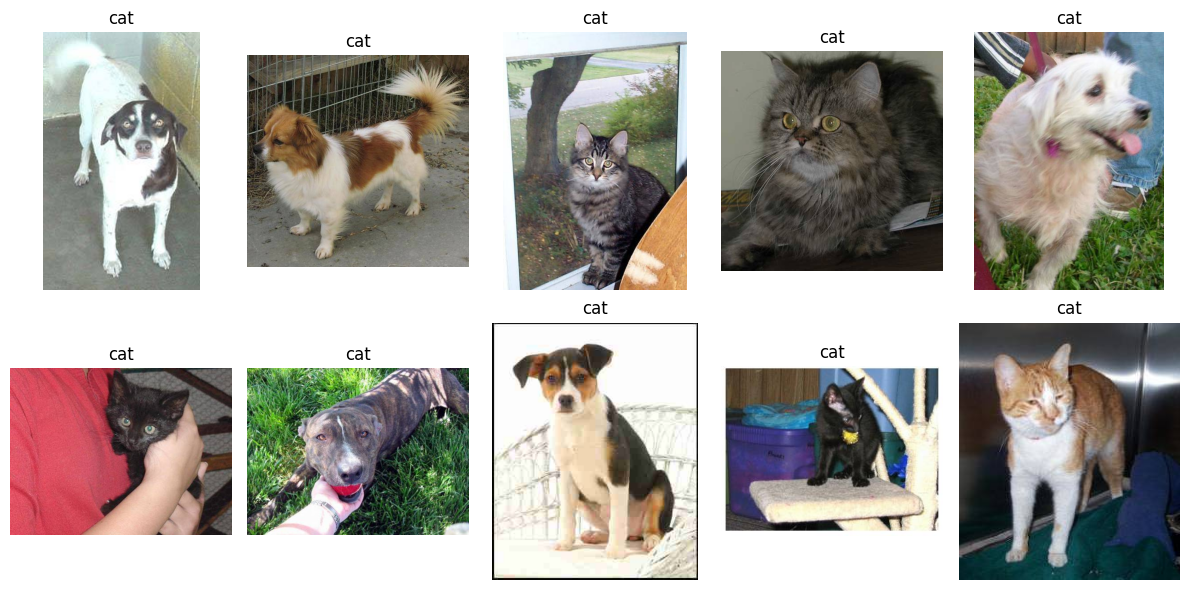

In [42]:
# 예측 결과에 대해 이미지와 함께 출력
display_image_grid(test_images_filepaths)